In [90]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

seed = 0

In [91]:
!pip install pyscipopt seaborn

In [92]:
from math import ceil, floor
import numpy as np


class Params:
    def __init__(self, var_idx: int, x_i: float, node_depth: int, nr_variables: int, curr_obj: float,
                 n_branches_by_var: int, n_nodes: int, downfrac: float, allowed_increase: float,
                 allowed_decrease: float,
                 upfrac: float, objective_increases: list, nr_fixed_variables: int, root_obj_val: float,
                 up_pseudo_cost: float, down_pseudo_cost: float, sense: str):
        self.var_idx = var_idx
        self.x_i = x_i
        self.node_depth = node_depth
        self.nr_variables = nr_variables
        self.nr_fixed_variables = nr_fixed_variables
        self.curr_obj = curr_obj
        self.n_branches_by_var = n_branches_by_var
        self.n_nodes = n_nodes
        self.down_frac = downfrac
        self.up_frac = upfrac
        self.allowed_decrease = allowed_decrease
        self.allowed_increase = allowed_increase
        self.objective_increases = objective_increases
        self.root_obj_val = root_obj_val
        self.up_pseudo_cost = up_pseudo_cost
        self.down_pseudo_cost = down_pseudo_cost
        self.sense = sense


def __static_feat(i: int, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    features = {}
    # 1st class
    # sign{c_i}
    c_i = c[i]
    features['sign'] = np.sign(c_i)

    # |c_i| / sum_{k: c_k >= 0} |c_k|
    pos_sum = np.sum(np.abs(c[c >= 0]))
    # |c_i| / sum_{k: c_k < 0} |c_k|
    neg_sum = np.sum(np.abs(c[c < 0]))

    features['c_i/sum_pos'] = abs(c_i) / pos_sum if pos_sum != 0 else 0
    features['c_i/sum_neg'] = abs(c_i) / neg_sum if neg_sum != 0 else 0

    # 2nd class
    # m_j^{+1}(i) = A_{ji}/|b_j|, forall j s.t. b_j >= 0
    M1_pos = []
    # m_j^{-1}(i) = A_{ji}/|b_j|, forall j s.t. b_j < 0
    M1_neg = []
    for j in range(A.shape[0]):
        a_ji = A[j, i]
        if b[j] >= 0:
            M1_pos.append(a_ji / abs(b[j]) if b[j] != 0 else 0)
        else:
            M1_neg.append(a_ji / abs(b[j]))

    features['M1_pos_min'] = np.min(M1_pos) if M1_pos else 0
    features['M1_pos_max'] = np.max(M1_pos) if M1_pos else 0
    features['M1_neg_min'] = np.min(M1_neg) if M1_neg else 0
    features['M1_neg_max'] = np.max(M1_neg) if M1_neg else 0

    # m_j^{2+} (i) = |c_i|/|A_{ji}| forall j s.t. c_i >= 0
    M2_pos = []
    # m_j^{2-} (i) = |c_i|/|A_{ji}| forall j s.t. c_i < 0
    M2_neg = []
    for j in range(A.shape[0]):
        if c[i] >= 0:
            M2_pos.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)
        else:
            M2_neg.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)

    features['M2_pos_min'] = np.min(M2_pos) if M2_pos else 0
    features['M2_pos_max'] = np.max(M2_pos) if M2_pos else 0
    features['M2_neg_min'] = np.min(M2_neg) if M2_neg else 0
    features['M2_neg_max'] = np.max(M2_neg) if M2_neg else 0

    M3_pp = []
    M3_pm = []
    M3_mp = []
    M3_mm = []

    for j in range(A.shape[0]):
        pos_sum = np.sum(np.abs(A[j, A[j] >= 0]))
        neg_sum = np.sum(np.abs(A[j, A[j] < 0]))

        a_ji = abs(A[j, i])
        if A[j, i] >= 0:
            M3_pp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_pm.append(a_ji / neg_sum if neg_sum != 0 else 0)
        else:
            M3_mp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_mm.append(a_ji / neg_sum if neg_sum != 0 else 0)

    features['M3_pp_min'] = np.min(M3_pp) if M3_pp else 0
    features['M3_pp_max'] = np.max(M3_pp) if M3_pp else 0
    features['M3_pm_min'] = np.min(M3_pm) if M3_pm else 0
    features['M3_pm_max'] = np.max(M3_pm) if M3_pm else 0
    features['M3_mp_min'] = np.min(M3_mp) if M3_mp else 0
    features['M3_mp_max'] = np.max(M3_mp) if M3_mp else 0
    features['M3_mm_min'] = np.min(M3_mm) if M3_mm else 0
    features['M3_mm_max'] = np.max(M3_mm) if M3_mm else 0

    return features


def __dynamic_feat(params: Params, c: np.ndarray):
    features = {}
    features['depth'] = params.node_depth / params.nr_variables
    features['fixed_vars'] = params.nr_fixed_variables / params.nr_variables

    features['min_xi'] = min(params.x_i - floor(params.x_i), ceil(params.x_i) - params.x_i)

    # sensitivity ranges
    c_i = c[params.var_idx]
    features['sign_allowed_decrease'] = np.sign(params.allowed_decrease)
    features['sign_allowed_increase'] = np.sign(params.allowed_increase)

    normalized_decrease = np.abs((c_i - params.allowed_decrease) / c_i)
    normalized_increase = np.abs((params.allowed_increase - c_i) / c_i)

    features['log_allowed_increase'] = np.log(normalized_increase) if normalized_increase != 0 else 0
    features['log_allowed_decrease'] = np.log(normalized_decrease) if normalized_decrease != 0 else 0

    features['down_frac'] = params.down_frac
    features['up_frac'] = params.up_frac

    return features


def __dynamic_opt_feat(params: Params):
    features = {}
    features['branching_ratio'] = params.n_branches_by_var / params.n_nodes

    features['min_obj_increase'] = np.min(params.objective_increases) if params.objective_increases else 0
    features['max_obj_increase'] = np.max(params.objective_increases) if params.objective_increases else 0
    features['avg_obj_increase'] = np.mean(params.objective_increases) if params.objective_increases else 0
    features['std_obj_increase'] = np.std(params.objective_increases) if params.objective_increases else 0

    # quartiles
    features['quartile_25_obj_increase'] = np.percentile(params.objective_increases,
                                                         25) if params.objective_increases else 0
    features['quartile_50_obj_increase'] = np.percentile(params.objective_increases,
                                                         50) if params.objective_increases else 0
    features['quartile_75_obj_increase'] = np.percentile(params.objective_increases,
                                                         75) if params.objective_increases else 0

    # divide all by curr_obj
    features['min_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['max_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['avg_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['std_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_25_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_50_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_75_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0

    features['up_pseudocost'] = params.up_pseudo_cost / params.root_obj_val if params.root_obj_val != 0 else 0
    features['down_pseudocost'] = params.down_pseudo_cost / params.root_obj_val if params.root_obj_val != 0 else 0
    return features


def compute_features(params: Params, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    static = __static_feat(params.var_idx, A, b, c)
    dynamic = __dynamic_feat(params, c)
    dynamic_opt = __dynamic_opt_feat(params)

    return {**static, **dynamic, **dynamic_opt}


In [93]:
from pyscipopt import Model, Branchrule, Variable
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd

class StrongBranchingRule(Branchrule):
    def __init__(self, model, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.dataset = pd.DataFrame()
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.objective_increases_by_var = defaultdict(list)
        self.down_pseudo_costs_history = defaultdict(float)
        self.up_pseudo_costs_history = defaultdict(float)
        self.root_obj_val = model.infinity() if model.getObjectiveSense() == "minimize" else -model.infinity()

    def branchexeclp(self, _):
        branch_cands, _, branch_cand_fracs, _, npriocands, _ = self.model.getLPBranchCands()

        # Initialise scores for each variable
        scores = [-self.model.infinity() for _ in range(npriocands)]
        down_bounds = [None for _ in range(npriocands)]
        up_bounds = [None for _ in range(npriocands)]

        # Initialise placeholder values
        num_nodes = self.model.getNNodes()
        lpobjval = self.model.getLPObjVal()
        lperror = False
        best_cand_idx = 0
        best_cand_gain = 0

        # Start strong branching and iterate over the branching candidates
        self.model.startStrongbranch()
        for i in range(npriocands):

            # Check the case that the variable has already been strong branched on at this node.
            # This case occurs when events happen in the node that should be handled immediately.
            # When processing the node again (because the event did not remove it), there's no need to duplicate work.
            if self.model.getVarStrongbranchNode(branch_cands[i]) == num_nodes:
                down, up, downvalid, upvalid, _, lastlpobjval = self.model.getVarStrongbranchLast(branch_cands[i])
                if downvalid:
                    down_bounds[i] = down
                if upvalid:
                    up_bounds[i] = up
                downgain = max([down - lastlpobjval, 0])
                upgain = max([up - lastlpobjval, 0])
                scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])
                continue

            # Strong branch
            down, up, downvalid, upvalid, downinf, upinf, downconflict, upconflict, lperror = self.model.getVarStrongbranch(
                branch_cands[i], 200, idempotent=False)

            # In the case of an LP error handle appropriately (for this example we just break the loop)
            if lperror:
                break

            # In the case of both infeasible sub-problems cutoff the node
            if downinf and upinf:
                return {"result": SCIP_RESULT.CUTOFF}

            # Calculate the gains for each up and down node that strong branching explored
            if not downinf and downvalid:
                down_bounds[i] = down
                downgain = max([down - lpobjval, 0])
            else:
                downgain = 0
            if not upinf and upvalid:
                up_bounds[i] = up
                upgain = max([up - lpobjval, 0])
            else:
                upgain = 0

            # Update the pseudo-costs
            lpsol = branch_cands[i].getLPSol()
            if not downinf and downvalid:
                self.model.updateVarPseudocost(branch_cands[i], -self.model.frac(lpsol), downgain, 1)
                self.down_pseudo_costs_history[branch_cands[i].name] = downgain / -self.model.frac(lpsol)
                self.objective_increases_by_var[branch_cands[i].name].append(downgain)
            if not upinf and upvalid:
                self.model.updateVarPseudocost(branch_cands[i], 1 - self.model.frac(lpsol), upgain, 1)
                self.up_pseudo_costs_history[branch_cands[i].name] = upgain / (1 - self.model.frac(lpsol))
                self.objective_increases_by_var[branch_cands[i].name].append(upgain)

            scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])

            if scores[i] > scores[best_cand_idx]:
                best_cand_idx = i

            self.n_branches_by_var[branch_cands[i].name] += 1
            features = self.extract_feats(branch_cand_fracs[i], branch_cands[i])
            curr_obj = self.model.getLPObjVal()
            features['score'] = scores[i] / np.abs(curr_obj) if curr_obj != 0 else 0
            row = pd.DataFrame.from_dict(features, orient='index').T
            self.dataset = pd.concat([self.dataset, row], ignore_index=True)

        # End strong branching
        self.model.endStrongbranch()

        # In the case of an LP error
        if lperror:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        down_child, _, up_child = self.model.branchVarVal(
            branch_cands[best_cand_idx], branch_cands[best_cand_idx].getLPSol())

        # Update the bounds of the down node and up node. Some cols might not exist due to pricing
        if self.model.allColsInLP():
            if down_child is not None and down_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(down_child, down_bounds[best_cand_idx])
            if up_child is not None and up_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(up_child, up_bounds[best_cand_idx])

        return {"result": SCIP_RESULT.BRANCHED}

    def n_fixed_vars(self):
        # from https://github.com/scipopt/PySCIPOpt/issues/347#issuecomment-602466658
        fixedvars = 0
        transvars = self.model.getVars(transformed=True)
        for var in transvars:
            if self.model.isFeasEQ(var.getLbLocal(), var.getUbLocal()):
                fixedvars += 1
        return fixedvars

    def get_sensitivity_range(self, var):
        # Get all variables in the LP
        all_vars = self.model.getVars(transformed=True)  # Get transformed vars for LP operations
        lp_cols_data = self.model.getLPColsData()
        lp_cols_map = {col.getLPPos(): col.getVar() for col in lp_cols_data}

        lp_basis_ind = self.model.getLPBasisInd()  # List of column indices in basis
        is_var_basic = False
        var_col = var.getCol()
        if var_col and var_col.getLPPos() != -1:  # Check if the variable is in the current LP formulation
            if var_col.getBasisStatus() == 'basic':
                is_var_basic = True

        obj_sense = self.model.getObjectiveSense()  # 'maximize' or 'minimize'

        if not is_var_basic:
            red_cost = self.model.getVarRedcost(var)
            current_obj_coeff = var.getObj()

            if obj_sense == 'maximize':
                allowable_increase = red_cost
                allowable_decrease = self.model.infinity()

                # Check for floating point issues: if red_cost is tiny negative, treat as 0
                if self.model.isLT(red_cost, 0):
                    allowable_increase = 0.0
            else:  # minimize
                allowable_increase = self.model.infinity()
                allowable_decrease = -red_cost
                # Check for floating point issues: if red_cost is tiny positive, treat as 0
                if self.model.isGT(red_cost, 0):
                    allowable_decrease = 0.0

            return current_obj_coeff - allowable_decrease, current_obj_coeff + allowable_increase

        else:
            allowable_increase = self.model.infinity()
            allowable_decrease = self.model.infinity()
            current_obj_coeff = var.getObj()

            # Find the row index of the basic variable 'var' in the basis
            # We need to find which basic variable in lp_basis_ind corresponds to 'var'
            basic_var_lp_pos = -1
            for i, col_idx in enumerate(lp_basis_ind):
                if col_idx >= 0:  # It's a column variable (not a slack/artificial)
                    bvar = lp_cols_map.get(col_idx)
                    if bvar and bvar.name == var.name:  # Match by name or some unique identifier
                        basic_var_lp_pos = i  # This is the row index in the basis
                        break

            if basic_var_lp_pos == -1:
                return None, None

            # Get the row from B^-1 A corresponding to the basic variable 'var'
            # This row contains the values (B^-1 A_j)_p for all non-basic columns j.
            # PySCIPOpt's getLPBInvARow returns a dense list where index corresponds to LP column index
            b_inv_a_row_for_var = self.model.getLPBInvARow(basic_var_lp_pos)

            # Iterate through all variables to find non-basic ones
            for non_basic_var in all_vars:
                non_basic_col = non_basic_var.getCol()

                # Ensure the non-basic variable is part of the LP and is indeed non-basic
                if (non_basic_col and non_basic_col.getLPPos() != -1 and
                        non_basic_col.getBasisStatus() in ['lower', 'upper', 'zero', 'free']):

                    nb_lp_pos = non_basic_col.getLPPos()
                    # Get the current reduced cost of the non-basic variable
                    original_red_cost_j = self.model.getVarRedcost(non_basic_var)

                    # This is the (B^-1 A_j)_p value, denoted as \bar{a}_{pj} in the explanation
                    a_bar_pj = b_inv_a_row_for_var[nb_lp_pos]

                    # Only consider non-zero a_bar_pj to avoid division by zero
                    if not self.model.isZero(a_bar_pj):
                        if obj_sense == 'maximize':
                            # New reduced cost: original_red_cost_j - Delta_c_k * a_bar_pj >= 0
                            # This is for maximization, so original_red_cost_j should be >= 0

                            # If a_bar_pj > 0: Delta_c_k <= original_red_cost_j / a_bar_pj
                            if self.model.isGT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_increase = min(allowable_increase, ratio)

                            # If a_bar_pj < 0: Delta_c_k >= original_red_cost_j / a_bar_pj
                            # This creates a lower bound for Delta_c_k (which is a negative value)
                            elif self.model.isLT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_decrease = min(allowable_decrease, -ratio)
                                allowable_decrease = min(allowable_decrease, -ratio)

                        else:  # minimize
                            if self.model.isGT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_decrease = min(allowable_decrease, ratio)
                            elif self.model.isLT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_increase = min(allowable_increase, -ratio)
                                allowable_increase = min(allowable_increase, -ratio)

            lower_bound = current_obj_coeff - allowable_decrease
            upper_bound = current_obj_coeff + allowable_increase

            return lower_bound, upper_bound

    def extract_feats(self, frac, var):
        allowable_increase, allowable_decrease = self.get_sensitivity_range(var)
        params = Params(
            var_idx=var.getCol().getLPPos(),
            x_i=var.getObj(),
            node_depth=self.model.getCurrentNode().getDepth(),
            nr_variables=self.model.getNVars(),
            curr_obj=self.model.getLPObjVal(),
            n_branches_by_var=self.n_branches_by_var[var.name],
            n_nodes=self.model.getNNodes(),
            downfrac=floor(frac),
            upfrac=ceil(frac),
            objective_increases=self.objective_increases_by_var[var.name],
            nr_fixed_variables=self.n_fixed_vars(),
            root_obj_val=self.model.getDualboundRoot(),
            up_pseudo_cost=np.mean(self.up_pseudo_costs_history[var.name]),
            down_pseudo_cost=np.mean(self.down_pseudo_costs_history[var.name]),
            allowed_decrease=allowable_decrease,
            allowed_increase=allowable_increase,
            sense=self.model.getObjectiveSense()
        )
        return compute_features(params, self.A, self.b, self.c)

In [94]:
from pyscipopt import Model, quicksum, SCIP_PARAMSETTING
from pyscipopt.scip import Term

MAX_BRANCHING_PRIORITY = 9999999
LEARNED_STRONG_BRANCHING = "learnedstrongbrnch"
RELIABILITY_BRANCHING = "relpscost"
PSEUDO_COST_BRANCHING = "pscost"
MOST_INFEASIBLE_BRANCHING = "mostinf"
RANDOM_BRANCHING = "random"

class Problem:
    def __init__(self, name, c, lb, ub, constraint_types, b, A, var_types=None, model=None):
        self.name = name
        self.c = c
        self.lb = lb
        self.ub = ub
        self.constraint_types = constraint_types
        self.var_types = var_types if var_types is not None else ['B'] * len(c)  # assuming binary
        self.b = b
        self.A = A

        self.model = model

    @staticmethod
    def from_model(path, name):
        model = Model()
        model.readProblem(path)
        model.setProbName(name)

        variables = model.getVars()
        constraints = model.getConss()

        # Initialize data structures
        n_vars = len(variables)
        n_cons = len(constraints)

        # Create mapping from variable to index
        c = np.zeros(n_vars)

        # Extract objective coefficients (vector c)
        for i, var in enumerate(variables):
            c[i] = model.getObjective().terms.get(Term(var), 0.0)

        variables = model.getVars()
        num_vars = len(variables)

        # Initialize A and b
        A = []
        b = []

        all_constraints = model.getConss()

        for con in all_constraints:
            assert con.isLinear(), "Only linear constraints are supported"

            # Get coefficients for this linear constraint
            coeffs = model.getValsLinear(con)

            # Create a row for the A matrix
            row = [0.0] * num_vars
            for var, coeff in coeffs.items():
                v = list(filter(lambda x: x.name == var, model.getVars()))[0]
                try:
                    # Find the index of the variable in our ordered list
                    var_index = v.getIndex()
                    row[var_index] = coeff
                except ValueError:
                    # This case should ideally not happen if getVars() gets all relevant variables,
                    # but it's good practice to handle unexpected variables.
                    print(
                        f"Warning: Variable {var.getName()} found in constraint {con.getName()} but not in model's getVars() list.")
                    pass

            rhs = model.getRhs(con)
            A.append(row)
            b.append(rhs)

        A = np.array(A)
        b = np.array(b)
        # lb, ub, constraint_types, and var_types are not needed if the model is already built
        return Problem(name, c=c, lb=[], ub=[], constraint_types=[], b=b, A=A, var_types=[], model=model)

    def solve_with_sb(self, logged=False):
        if self.model is None:
            self.build_model()
        self.basic_config(logged=logged)
        self.disable_configs()
        sb = StrongBranchingRule(self.model, self.A, self.b, self.c, logged)
        self.model.includeBranchrule(            sb,
            "customstrbrnch",
            "Custom strong branching rule for learning",
            priority=MAX_BRANCHING_PRIORITY,
            maxbounddist=1.0
        )
        self.model.optimize()
        assert self.model.getStatus() == "optimal", f"Model {self.model.getProbName()} did not solve to optimality. Status: {self.model.getStatus()}"

        stats = {            
            'time': self.model.getSolvingTime(),
            'n_vars': len(self.c),
            'n_constraints': len(self.b),
            'name': self.name,
            'n_nodes': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        self.model.freeProb()
        return sb.dataset, stats

    def solve_with_rule(self, branching_strategy, predictor=None, predictor_name=None, logged=False, max_nodes=-1, timelimit=-1):
        if self.model is None:
            self.build_model()
        self.basic_config(logged=logged)
        self.disable_configs()

        if branching_strategy == LEARNED_STRONG_BRANCHING:
            assert predictor is not None, "Predictor must be provided for learned strong branching"
            assert predictor_name is not None, "Predictor name must be provided for learned strong branching"
            self.model.includeBranchrule(
                LearnedStrongBranching(self.model, predictor, self.A, self.b, self.c, logged),
                LEARNED_STRONG_BRANCHING,
                "Learned Strong Branching Rule",
                priority=MAX_BRANCHING_PRIORITY,
                maxdepth=-1,  # No depth limit
                maxbounddist=1.0
            )
        else:
            self.model.setIntParam(f'branching/{branching_strategy}/priority', MAX_BRANCHING_PRIORITY)

        self.model.setLongintParam('limits/nodes', max_nodes if max_nodes > 0 else -1)
        self.model.setRealParam('limits/time', timelimit if timelimit > 0 else -1)
        try:
            self.model.optimize()
        except Exception as e:
            print(f"Error during optimization: {e}")
            return None

        stats = {
            'time': self.model.getSolvingTime(),
            'n_vars': len(self.c),
            'n_constraints': len(self.b),
            'name': self.name,
            'n_nodes': self.model.getNNodes(),
            'gap': self.model.getGap(),
            'status': self.model.getStatus(),
            'time_limit': timelimit if timelimit > 0 else -1,
            'node_limit': max_nodes if max_nodes > 0 else -1,
            'strategy': branching_strategy,
            'predictor': predictor_name if branching_strategy == LEARNED_STRONG_BRANCHING else None
        }
        return stats

    def build_model(self, disable_cuts=True, disable_heuristics=True, disable_presolving=True):
        model = Model(self.name)
        n_vars = len(self.c)
        x = []
        for i in range(n_vars):
            if self.var_types[i] == 'B':
                x.append(model.addVar(name=f"x_{i}", vtype="B"))
            elif self.var_types[i] == 'C':
                x.append(model.addVar(name=f"x_{i}", vtype="C", lb=self.lb[i], ub=self.ub[i]))

        # Set objective function
        model.setObjective(quicksum(self.c[i] * x[i] for i in range(n_vars)), "minimize")

        n_constraints = len(self.b)
        if n_constraints != len(self.constraint_types):
            raise Exception(
                f"Number of constraints ({n_constraints}) doesn't match number of types ({len(self.constraint_types)})")

        # Add constraints
        for i in range(n_constraints):
            lhs = quicksum(self.A[i][j] * x[j] for j in range(n_vars) if self.A[i][j] != 0)

            if self.constraint_types[i] == 'E':
                model.addCons(lhs == self.b[i])
            elif self.constraint_types[i] == 'G':
                model.addCons(lhs >= self.b[i])
            elif self.constraint_types[i] == 'L':
                model.addCons(lhs <= self.b[i])

        assert (model.getNConss() == len(
            self.A)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNConss() == len(
            self.b)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNVars() == len(
            self.c)), "Number of variables in model doesn't match number of variables in problem"
        self.model = model

    def basic_config(self, logged=False, max_nodes=-1, timelimit=-1):
        if self.model is None:
            raise Exception("Model is not built yet. Call __build_model() first.")

        if not logged:
            self.model.hideOutput()
            self.model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            self.model.setIntParam('display/verblevel', 3)  # Verbose output

        if max_nodes > 0:
            self.model.setIntParam('limits/nodes', max_nodes)

        if timelimit > 0:
            self.model.setRealParam('limits/time', timelimit)

        self.model.setIntParam('display/freq', 500)  # logging frequency

    def disable_configs(self):
        self.model.setPresolve(SCIP_PARAMSETTING.OFF)
        self.model.setSeparating(SCIP_PARAMSETTING.OFF)
        self.model.setHeuristics(SCIP_PARAMSETTING.OFF)

    def __repr__(self):
        return f"Problem(name={self.name})"



In [95]:
import numpy as np

"""
Formulation
min k = sum_{j in J} y_j
s.t.
     k >= 1
     sum_{i in I} s(i) x_{ij} <= B y_i forall j in J
     sum_{j in J} x_{ij} = 1 forall i in I

     y_j in {0,1} forall j in J
     x_{ij} in {0,1} forall i in I, j in J

     x_{ij} in {0,1} forall i in I, j in J
     y_j in {0,1} forall j in J

     I: items, J: bins
     s(i): size of item i
     B: bin capacity
"""


def bin_packing(n_problems: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                item_size: (float, float)):
    return [__generate_bp(i, items, bins, bin_capacity, item_size) for i in range(n_problems)]


def __generate_bp(id: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                  item_size: (float, float)):
    n_items = np.random.randint(*items)
    n_bins = np.random.randint(*bins)
    bin_capacity = np.random.uniform(*bin_capacity)
    item_sizes = np.random.uniform(*item_size, size=n_items)
    n_vars = n_bins + n_items * n_bins  # y_i + x_{ij}
    assert n_vars < 1000, "Community edition has a limit of 1000 variables"

    c = np.concatenate([
        np.ones(n_bins),  # cost for bins (y_j)
        np.zeros(n_items * n_bins)  # no cost for x_{ij} (multiplying n_items * n_bins as x has 2 indexes)
    ])

    A, b, types = [], [], []

    ## constraints
    # k >= 1
    A.append(np.concatenate([np.zeros(n_bins), np.ones(n_items * n_bins)]))
    b.append(1)
    types.append('G')

    # sum(s(i) * x_ij) <= B * y_j for all j
    for j in range(n_bins):
        row = np.zeros(n_vars)
        row[j] = -bin_capacity  # coefficient for y_j
        for i in range(n_items):
            row[n_bins + i * n_bins + j] = item_sizes[i]  # coefficient for x_{ij}
        A.append(row)
        b.append(0)
        types.append('L')

    # sum(x_ij) = 1 for all i
    for i in range(n_items):
        row = np.zeros(n_vars)
        for j in range(n_bins):
            row[n_bins + i * n_bins + j] = 1  # coefficient for x_{ij}
        A.append(row)
        b.append(1)
        types.append('E')

    A = np.array(A)
    b = np.array(b)
    assert A.shape[0] == b.shape[0], "A and b must have the same number of rows"

    types = np.array(types)

    return Problem(
        name=f"randomBP_{id}",
        c=c,
        lb=[0] * n_vars,
        ub=[1] * n_vars,
        constraint_types=types,
        b=b,
        A=A
    )


In [96]:
import numpy as np

"""
Formulation
min sum_{s in S} x_s
s.t. sum_{s: e in s} x_s >= 1 forall e in E
x in {0,1}^n
"""

A_DENSITY = 0.3


def set_cover(n_problems: int, universe_size_range=(50, 70)):
    return [__generate_sc(i, universe_size_range) for i in range(n_problems)]


def __generate_sc(id: int, universe_size_range):
    # universe selection
    universe_size = np.random.randint(*universe_size_range)
    universe = np.random.choice(list(range(1, 100)), size=universe_size, replace=False)

    binary_matrix = np.random.randint(0, 2, size=(len(universe), len(universe)))

    # Ensure each row and column has at least one 1 to avoid empty sets
    for i in range(binary_matrix.shape[0]):
        if np.sum(binary_matrix[i, :]) == 0:
            binary_matrix[i, np.random.randint(0, binary_matrix.shape[1])] = 1

    for j in range(binary_matrix.shape[1]):
        if np.sum(binary_matrix[:, j]) == 0:
            binary_matrix[np.random.randint(0, binary_matrix.shape[0]), j] = 1

    # mapping to universe elements
    subsets = []
    for j in range(binary_matrix.shape[1]):
        subset = []
        for i in range(binary_matrix.shape[0]):
            if binary_matrix[i, j] == 1:
                subset.append(universe[i])
        subsets.append(subset)

    # remove duplicated sets from subsets
    unique_subsets = []
    for subset in subsets:
        if subset not in unique_subsets:
            unique_subsets.append(subset)

    # shuffling within subsets
    for i in range(len(unique_subsets)):
        np.random.shuffle(unique_subsets[i])

    # Create Problem object
    n_subsets = len(unique_subsets)
    n_elements = len(universe)

    A = np.zeros((n_elements, len(unique_subsets)))
    for j, subset in enumerate(unique_subsets):
        for elem in subset:
            i, = np.where(universe == elem)
            A[i, j] = 1

    c = np.ones(len(unique_subsets))
    b = np.ones(n_elements)
    types = ['G'] * n_elements

    return Problem(
        name=f"randomSC_{id}",
        c=c,
        lb=[0] * n_subsets,
        ub=[1] * n_subsets,
        constraint_types=types,
        b=b,
        A=A,
    )


In [97]:
def solve(problems, name, export_path):
    if len(problems) == 0:
        return

    dataset_name = f"{export_path}/{name}_solution.csv"
    stats_name = f"{export_path}/{name}_stats.csv"

    dataset = pd.read_csv(dataset_name) if os.path.exists(dataset_name) else pd.DataFrame()
    stats = pd.read_csv(stats_name) if os.path.exists(stats_name) else pd.DataFrame()

    for problem in tqdm(problems, desc=f"Solving problems {name}", unit="problem"):
        try:
            names = stats['name'].values if stats.get('name', None) is not None else []
            if not problem.name in names:
                solution, stats_result = problem.solve_with_sb(logged=False)
                dataset = pd.concat([dataset, solution], ignore_index=True)
                stats_row = pd.DataFrame.from_dict(stats_result, orient='index').T
                stats = pd.concat([stats, stats_row], ignore_index=True)
                print(f"Problem {problem.name} solved in {stats_result['time']} seconds")
                # overwrite dataset and stats files
                dataset.to_csv(f"{export_path}/{name}_solution.csv")
                stats.to_csv(f"{export_path}/{name}_stats.csv")
            else:
                print(f"Problem {problem.name} already solved, skipping.")
        except AssertionError as e:
            print(f"Problem has no solution: {problem.name}")
        except Exception as e:
            print(f"Error solving problem {problem.name}: {e}")
            continue

In [98]:
import os


def export_generated_probs(probs, src):
    # check if generated problems have already been exported
    if len(os.listdir(src)) == 0:
        for prob in probs:
            filename = f"{src}/{prob.name}.lp"
            if not os.path.exists(filename):
                prob.build_model()
                prob.model.writeProblem(filename)

In [99]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

np.random.seed(seed)

bp = bin_packing(
    n_problems=100,
    items=(10, 20),
    bins=(5, 10),
    bin_capacity=(0.5, 1.5),
    item_size=(0.1, 0.9),
)

sc = set_cover(
    n_problems=100,
    universe_size_range=(80, 100),
)

os.makedirs("sources/randomBP", exist_ok=True)
os.makedirs("sources/randomSC", exist_ok=True)
export_generated_probs(sc, "sources/randomSC")
export_generated_probs(bp, "sources/randomBP")


In [100]:
import kagglehub

import kagglehub
import os

out = "output/"


def load_and_solve_probs():
    lp_probs_path = kagglehub.dataset_download("elenaferr0/lp-probs")

    mknsc_train_path = f"{lp_probs_path}/LP-Probs/MKNSCtrain"
    mknsc_test_path = f"{lp_probs_path}/LP-Probs/MKNSCtest"
    bpeq_train_path = f"{lp_probs_path}/LP-Probs/BPEQtrain"
    bpeq_test_path = f"{lp_probs_path}/LP-Probs/BPEQtest"
    bpsc_test_path = f"{lp_probs_path}/LP-Probs/BPSCtest"

    mknsc_train = [Problem.from_model(file) for file in os.listdir(mknsc_train_path)]
    mknsc_test = [Problem.from_model(file) for file in os.listdir(mknsc_test_path)]
    bpeq_train = [Problem.from_model(file) for file in os.listdir(bpeq_train_path)]
    bpeq_test = [Problem.from_model(file) for file in os.listdir(bpeq_test_path)]
    bpsc_test = [Problem.from_model(file) for file in os.listdir(bpsc_test_path)]

    solve(mknsc_train, "mknsc_train", out)
    solve(mknsc_test, "mknsc_test", out)
    solve(bpeq_train, "bpeq_train", out)
    solve(bpeq_test, "bpeq_test", out)
    solve(bpsc_test, "bpsc_test", out)


In [13]:
sln_path = kagglehub.dataset_download("elenaferr0/strongbranchingscores")
sln_path = f"{sln_path}/Solutions"
if os.listdir(sln_path) == 0:
    load_and_solve_probs()

    sc_train, sc_test = train_test_split(sc, test_size=0.2)
    bp_train, bp_test = train_test_split(bp, test_size=0.2)

    solve(sc_train, f"randomSC_train", out)
    solve(sc_test, f"randomSC_test", out)

    solve(bp_train, f"randomBP_train", out)
    solve(bp_test, f"randomBP_test", out)
    stats_path = out

print(sln_path)
print(os.listdir(sln_path))

100%|██████████| 583M/583M [01:38<00:00, 6.23MB/s] 

Extracting files...


/Users/elenaferro/.cache/kagglehub/datasets/elenaferr0/strongbranchingscores/versions/11/Solutions
['mknsc_test_solution.csv', 'bpeq_test_solution.csv', 'mknsc_train_solution.csv', 'randomSC_test_solution.csv', 'bpsc_train_solution.csv', 'randomSC_train_solution.csv', 'bpeq_train_solution.csv', 'randomBP_test_solution.csv', 'miplib_test_solution.csv', 'randomBP_train_solution.csv']


## Dataset loading (read generated csv files)

In [16]:
import pandas as pd

train_csv = [
    'randomSC_train_solution.csv',
    'randomBP_train_solution.csv',
    'mknsc_train_solution.csv',
    'bpeq_train_solution.csv',
]

test_csv = [
    'miplib_test_solution.csv',
    'randomSC_test_solution.csv',
    'randomBP_test_solution.csv',
    'bpeq_test_solution.csv',
    'bpsc_test_solution.csv',
]

files = list(map(lambda x: pd.read_csv(f"{sln_path}/{x}"), train_csv))
train = pd.concat(files, ignore_index=True)
train = train.sample(n=10 ** 5, random_state=seed, ignore_index=True)

files = list(map(lambda x: pd.read_csv(f"{sln_path}/{x}"), test_csv))
test = pd.concat(files, ignore_index=True)
test = test.sample(n=20000, random_state=seed, ignore_index=True)

X_train = train.drop(columns=['score'])
print(f'Train set size: {X_train.shape}')
y_train = train['score']

X_test = test.drop(columns=['score'])
print(f'Test set size: {X_test.shape}')
y_test = test['score']

Train set size: (100000, 38)
Test set size: (20000, 38)


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer


def feature_processing(regressor):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()),
        ('predictor', regressor)
    ])


def create_pipeline(regressor):
    return TransformedTargetRegressor(
        regressor=feature_processing(regressor),
        func=np.log1p,
        inverse_func=np.expm1,
    )

## Preprocessing

### PCA

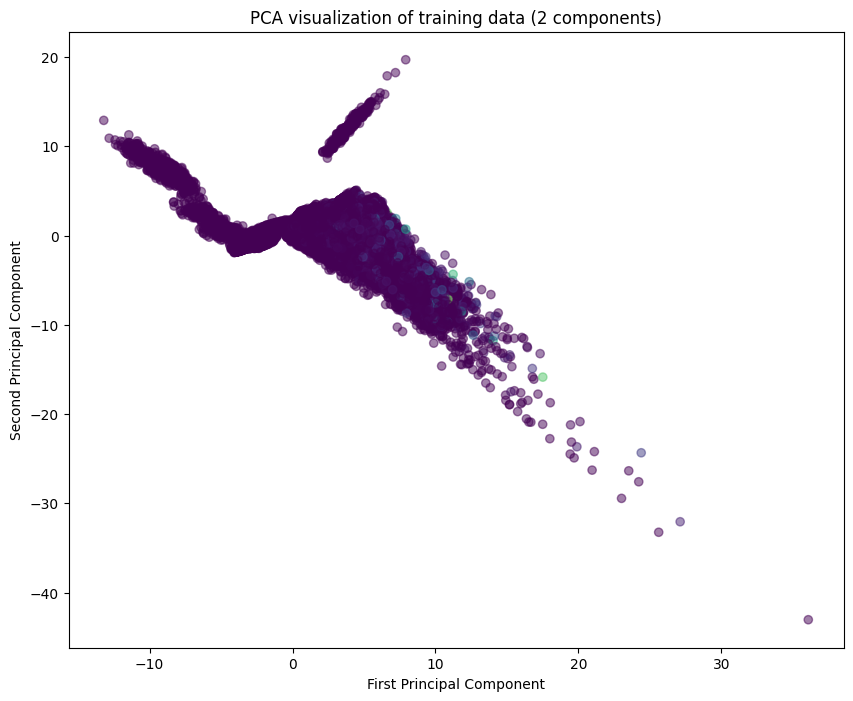

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# First PCA visualization
pipeline = feature_processing(PCA(n_components=2))
pipeline.fit(X_train, y_train)
X_pca = pipeline.transform(X_train)

plt.figure(figsize=(10, 8))
plt.title('PCA visualization of training data (2 components)')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [19]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached cma-3.2.2-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached alive_progress-3.2.0-py3-none-any.whl.metadata (70 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached about_time-4.2.1-py3-none-any.whl.metadata (13 kB)
  Using cached grapheme-0.6.0.tar.gz (207 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached cma-3.2.2-py2.py3-none-any.whl (249 kB)
Using cached autograd-1.8.0-py3-none-any.whl (51 kB)
Using cached alive_progress-3.2.0-py3-none-any.whl (77 kB)
Using cached about_time-4.2.1-py3-n

In [ ]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import string, itertools

def find_minimization_pareto_front(df, x_col, y_col):
    costs = np.column_stack([df[x_col], df[y_col]])
    nds = NonDominatedSorting()
    front = nds.do(costs, only_non_dominated_front=True)
    pareto_front_idx = np.zeros(len(costs), dtype=bool)
    pareto_front_idx[front] = True
    return pareto_front_idx

double_letter = [''.join(combo) for combo in itertools.product(string.ascii_uppercase, repeat=2)]

def label_results(results_df):
    identifiers = double_letter[:results_df.shape[0]]
    results_df['config_id'] = identifiers
    return results_df

def regr_refit_strategy(cv_results):
    results_df = pd.DataFrame(cv_results)
    results_df = label_results(results_df)

    results_df['pos_mse'] = results_df['mean_test_neg_mean_squared_error'].abs()

    # find the pareto front (best tradeoffs)
    pareto_front_indexes = find_minimization_pareto_front(results_df, 'mean_score_time', 'pos_mse')

    # find the one nearest to the centroid
    pareto_df = results_df.loc[pareto_front_indexes].copy()
    pareto_centroid = pareto_df[['mean_score_time', 'pos_mse']].mean().values
    pareto_df['distance'] = np.sqrt(
        (pareto_df['mean_score_time'] - pareto_centroid[0]) ** 2 +
        (pareto_df['pos_mse'] - pareto_centroid[1]) ** 2
    )
    pareto_df = pareto_df.sort_values(by='distance')
    # return the index of the best tradeoff
    idx_min = pareto_df.index[0]
    return idx_min

In [ ]:
import seaborn as sns

def plot_results(results_df, pareto_front_idx, chosen_idx):
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(data=results_df, x='mean_score_time', y='pos_mse', label='All Configurations', color='gray',
                         alpha=0.6)

    # Highlight Pareto front points (except chosen one)
    pareto_df = results_df.loc[pareto_front_idx]
    sns.scatterplot(data=pareto_df[pareto_df.index != chosen_idx], x='mean_score_time', y='pos_mse',
                    label='Pareto Front', color='#2ca25f', ax=ax)

    # Highlight chosen point
    chosen_point = results_df.loc[[chosen_idx]]
    chosen_point_label = chosen_point['config_id'].values[0]
    sns.scatterplot(data=chosen_point, x='mean_score_time', y='pos_mse', label=f'Chosen config ({chosen_point_label})',
                    color='#ff7f0e', ax=ax)
    display("Chosen params", chosen_point['params'].iloc[0])

    plt.title('Mean Score Time vs. MSE')
    plt.xlabel('Mean Score Time (s)')
    plt.ylabel('Mean Squared Error (MSE)')

    plt.grid(True, linestyle='--', alpha=0.4)

    for i in range(results_df.shape[0]):
        x = results_df['mean_score_time'].iloc[i]
        y = results_df['pos_mse'].iloc[i]
        label = results_df['config_id'].iloc[i]
        ax.annotate(str(label), (x, y), textcoords="offset points", xytext=(10, 10), ha='left', fontsize=12)

    fig = plt.gcf()
    fig.subplots_adjust(right=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
from IPython.display import display

metrics = pd.DataFrame()

def print_metrics(cv_results, best_index, name):
    global metrics
    mse = -cv_results['mean_test_neg_mean_squared_error'][best_index]
    rmse = -cv_results['mean_test_neg_root_mean_squared_error'][best_index]
    r2 = cv_results['mean_test_r2'][best_index]
    me = -cv_results['mean_test_neg_max_error'][best_index]
    fit_time = cv_results['mean_score_time'][best_index]

    new_row_data = {
        'Model': name,
        'R² Score': r2,
        'MSE': mse,
        'RMSE': rmse,
        'Max Error': me,
        'Score Time (s)': fit_time
    }

    new_row_df = pd.DataFrame([new_row_data])
    display(f"Test set evaluation metrics for **{name}**", new_row_df.T)
    metrics = pd.concat([metrics, new_row_df], ignore_index=True)

## Extra Trees Regressor

In [45]:
predictors = {}

In [46]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2', 'neg_max_error']

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

# {'regressor__predictor__max_depth': 20,
#  'regressor__predictor__max_features': None,
#  'regressor__predictor__min_samples_leaf': 5,
#  'regressor__predictor__min_samples_split': 2,
#  'regressor__predictor__n_estimators': 30}

params = {
    "regressor__predictor__n_estimators": [10, 20, 30],
    "regressor__predictor__min_samples_leaf": [5, 10],
    "regressor__predictor__max_depth": [10, 20],
    "regressor__predictor__max_features": ['sqrt', None],
    "regressor__predictor__min_samples_split": [2, 5, 10],
}
et = ExtraTreesRegressor(random_state=seed)
ert_pipeline = create_pipeline(et)

gs = GridSearchCV(ert_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'ExtraTreeRegressor')
predictors['ExtraTreeRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Test set evaluation metrics for **ExtraTreeRegressor**'

,0
Model,ExtraTreeRegressor
R² Score,0.899555
MSE,0.12886
RMSE,0.35445
Max Error,-26.12364
Score Time (s),0.070499


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "regressor__predictor__n_estimators": [10, 20, 25],
    "regressor__predictor__min_samples_leaf": [5, 10, 20],
    "regressor__predictor__max_depth": [10, 20],
    "regressor__predictor__max_features": ['sqrt', None]
}
rfr = RandomForestRegressor(random_state=seed)
rfr_pipeline = create_pipeline(rfr)

gs = GridSearchCV(rfr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'RandomForestRegressor')
predictors['RandomForestRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Test set evaluation metrics for **RandomForestRegressor**'

,0
Model,RandomForestRegressor
R² Score,0.946839
MSE,0.06746
RMSE,0.256878
Max Error,-14.208266
Score Time (s),0.044696


## Single decision tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "regressor__predictor__min_samples_leaf": [2, 5, 10],
    "regressor__predictor__max_depth": [20, 30, None],
    "regressor__predictor__min_samples_split": [2, 5]
}

dt = DecisionTreeRegressor(random_state=seed)
dt_pipeline = create_pipeline(dt)

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'DecisionTreeRegressor')
predictors['DecisionTreeRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Test set evaluation metrics for **DecisionTreeRegressor**'

,0
Model,DecisionTreeRegressor
R² Score,0.916727
MSE,0.103783
RMSE,0.321927
Max Error,-20.163712
Score Time (s),0.010788


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

params = {
    'regressor__predictor__alpha': [0.05, 0.3, 0.5, 1, 2, 3]
}

lasso_pipeline = create_pipeline(Lasso(random_state=seed))
gs = GridSearchCV(lasso_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'Lasso')
predictors['Lasso'] = gs.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


'Test set evaluation metrics for **Lasso**'

,0
Model,Lasso
R² Score,0.110017
MSE,1.121182
RMSE,1.057613
Max Error,-41.487623
Score Time (s),0.008965


In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lr_pipeline = create_pipeline(LinearRegression())
scores = cross_validate(lr_pipeline, X_train, y_train, cv=5, scoring=scoring)
new_row_data = {
    'Model': 'LinearRegression',
    'R² Score': np.mean(scores['test_r2']),
    'MSE': -np.mean(scores['test_neg_mean_squared_error']),
    'RMSE': -np.mean(scores['test_neg_root_mean_squared_error']),
    'Max Error': -np.mean(scores['test_neg_max_error']),
    'Score Time (s)': np.mean(scores['score_time'])
}

new_row_df = pd.DataFrame([new_row_data])
display(new_row_df.T)
metrics = pd.concat([metrics, new_row_df], ignore_index=True)
predictors['LinearRegression'] = lr_pipeline

,0
Model,LinearRegression
R² Score,0.160379
MSE,1.058135
RMSE,1.027307
Max Error,40.67851
Score Time (s),0.009407


# imodels rules

In [52]:
!pip install imodels

/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=40768) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [ ]:
from imodels import GreedyTreeRegressor

params = {
    'regressor__predictor__min_samples_leaf': [5, 10, 20],
    'regressor__predictor__max_depth': [3, 5, 10],
    'regressor__predictor__max_features': [None, 'sqrt']
}

gtr_pipeline = create_pipeline(GreedyTreeRegressor(random_state=seed))
gs = GridSearchCV(gtr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'GreedyTreeRegressor')
predictors['GreedyTreeRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


'Test set evaluation metrics for **GreedyTreeRegressor**'

,0
Model,GreedyTreeRegressor
R² Score,0.917356
MSE,0.10302
RMSE,0.320771
Max Error,-20.163712
Score Time (s),0.011741


In [ ]:
from imodels import BoostedRulesRegressor

params = {
    'regressor__predictor__learning_rate': [0.25, 0.5, 1, 5],
    'regressor__predictor__n_estimators': [10, 20, 30],
}

brr_pipeline = create_pipeline(BoostedRulesRegressor(random_state=seed))
gs = GridSearchCV(brr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'BoostedRulesRegressor')
predictors['BoostedRulesRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Test set evaluation metrics for **BoostedRulesRegressor**'

,0
Model,BoostedRulesRegressor
R² Score,0.235965
MSE,0.961242
RMSE,0.979577
Max Error,-38.378597
Score Time (s),0.025351


In [56]:
!pip install lightgbm

/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=40768) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [57]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'regressor__predictor__n_estimators': [2, 3, 5],
    'regressor__predictor__learning_rate': [0.05, 0.1, 0.5],
    'regressor__predictor__num_leaves': [10, 31]
}

lgbm_pipeline = create_pipeline(LGBMRegressor(random_state=seed, objective='regression', metric=scoring, verbose=0))
gs = GridSearchCV(lgbm_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train.values, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'LGBMRegressor')
predictors['LGBMRegressor'] = gs.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  war

'Test set evaluation metrics for **LGBMRegressor**'

,0
Model,LGBMRegressor
R² Score,0.915621
MSE,0.106751
RMSE,0.325294
Max Error,-18.918527
Score Time (s),0.010371


,Model,R² Score,MSE,RMSE,Max Error,Score Time (s)
0,ExtraTreeRegressor,0.899555,0.128860,0.354450,-26.123640,0.070499
1,RandomForestRegressor,0.946839,0.067460,0.256878,-14.208266,0.044696
2,DecisionTreeRegressor,0.916727,0.103783,0.321927,-20.163712,0.010788
3,Lasso,0.110017,1.121182,1.057613,-41.487623,0.008965
4,LinearRegression,0.160379,1.058135,1.027307,40.678510,0.009407
5,GreedyTreeRegressor,0.917356,0.103020,0.320771,-20.163712,0.011741
6,BoostedRulesRegressor,0.235965,0.961242,0.979577,-38.378597,0.025351
7,LGBMRegressor,0.915621,0.106751,0.325294,-18.918527,0.010371


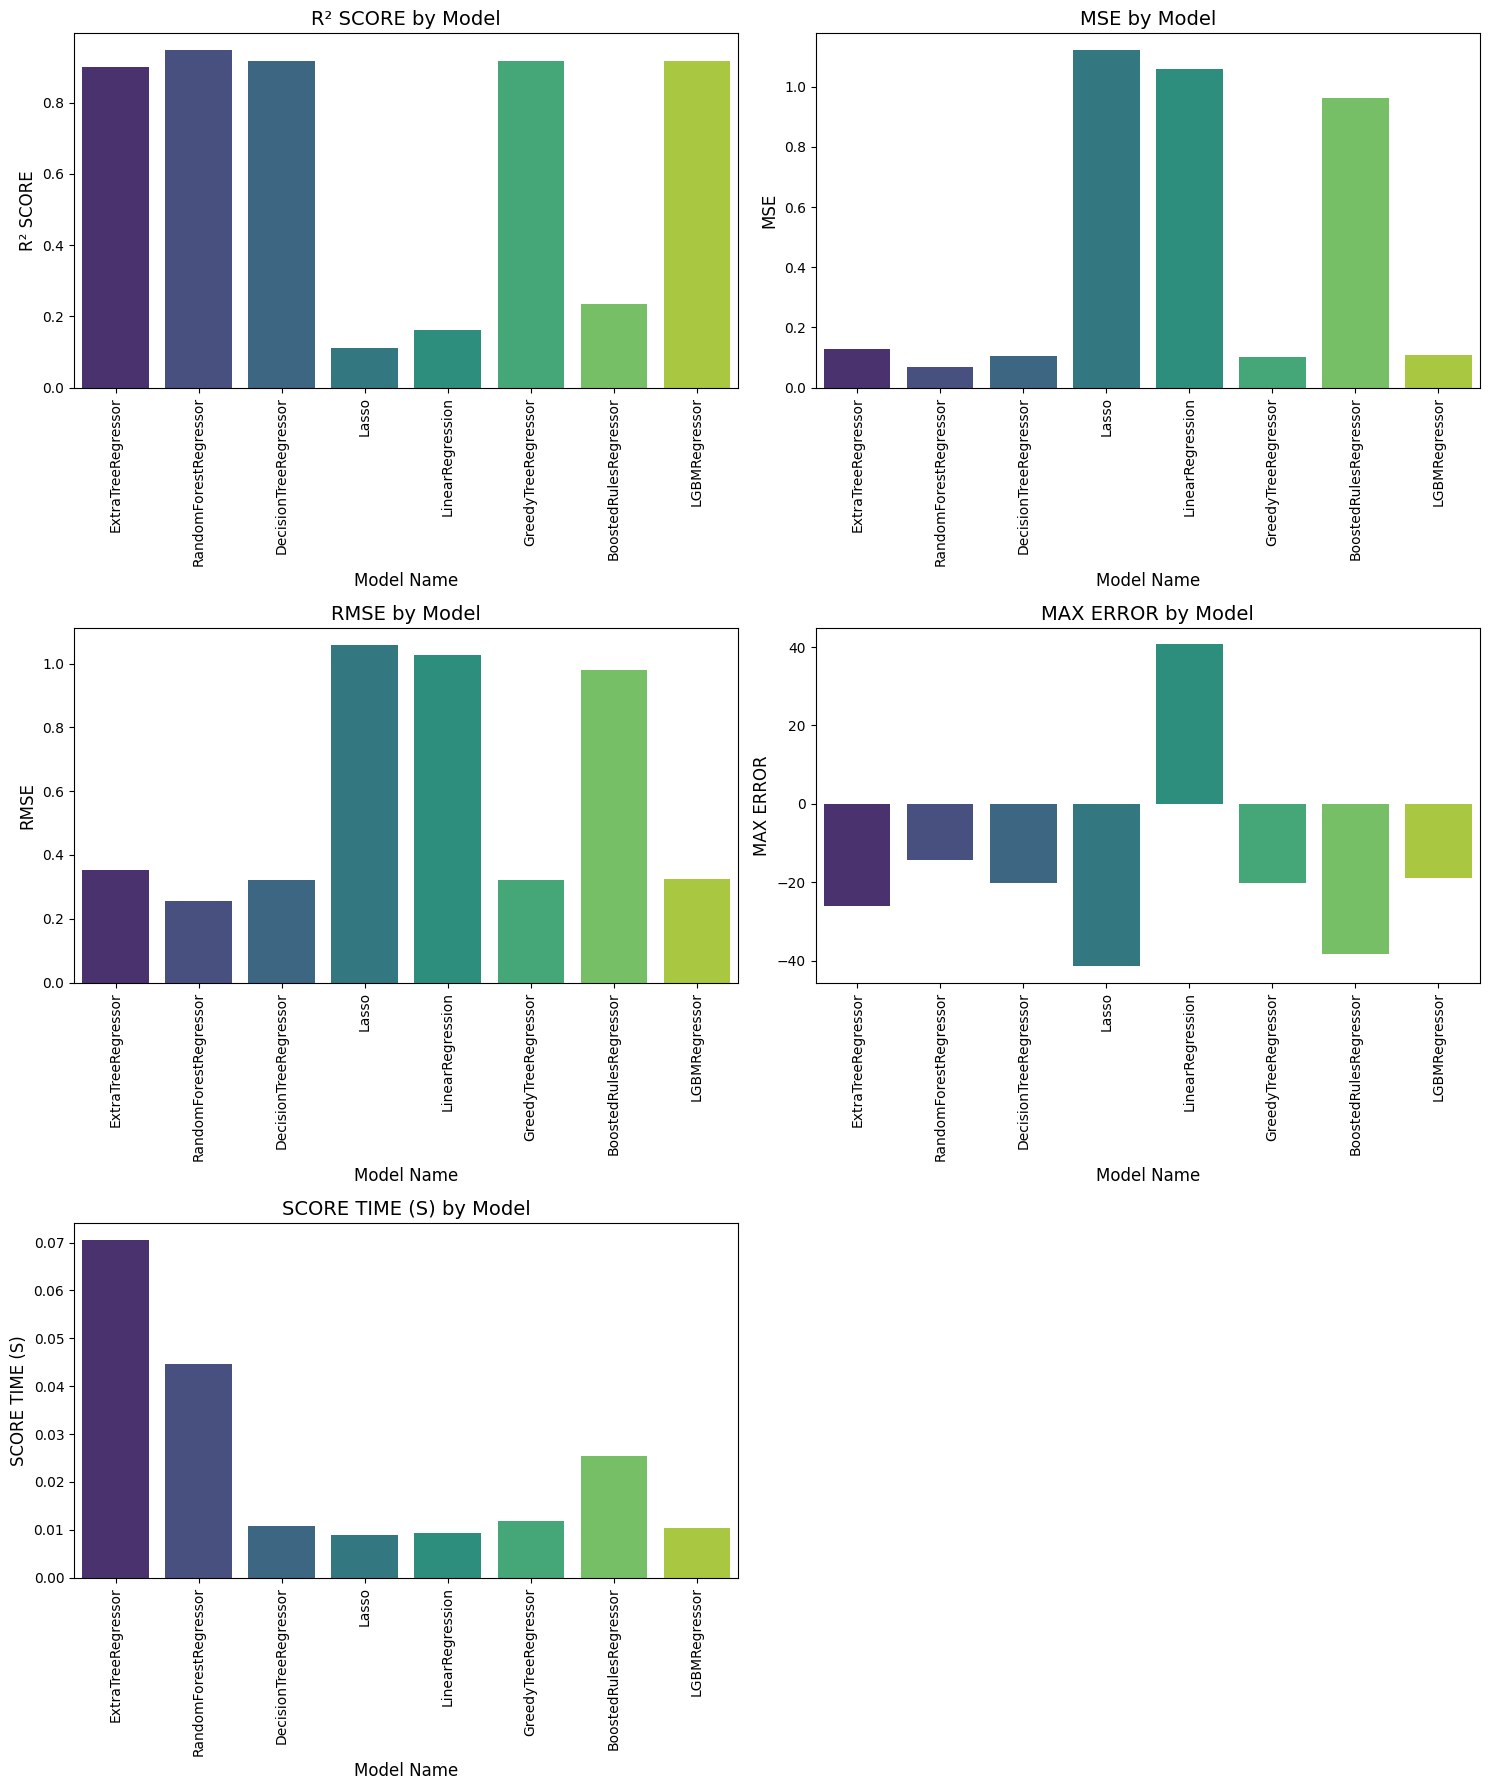

In [65]:
display(metrics)

#all metrics except name
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Plot each metric
metric_columns = [col for col in metrics.columns if col != 'Model']
for i, metric in enumerate(metric_columns):
    sns.barplot(x='Model', y=metric, data=metrics, ax=axes[i], palette='viridis')
    
    # Format each subplot
    axes[i].set_title(f'{metric.upper()} by Model', fontsize=14)
    axes[i].set_xlabel('Model Name', fontsize=12)
    axes[i].set_ylabel(metric.upper(), fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)

# Remove the empty subplot if there is one
if len(metric_columns) < len(axes):
    fig.delaxes(axes[-1])

# Adjust layout and display
plt.tight_layout()
plt.show()

## RIPPER

In [ ]:
!pip install wittgenstein

In [ ]:
import wittgenstein as lw
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from datetime import datetime

params = {
    'predictor__es__k': [1, 2, 3],
    'predictor__es__prune_size': [0.15, 0.33, 0.5],
    'predictor__es__max_rules': [3, 5, 8, 10, 15],
}

discretizer = ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
ripper_pipeline = create_pipeline(OneVsRestClassifier(lw.RIPPER(random_state=seed, n_discretize_bins=None)),
                                  additional_pre_steps=[discretizer])

gs = GridSearchCV(ripper_pipeline, param_grid=params, cv=5, scoring='accuracy', verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print(gs.cv_results_)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_encoded, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cross Validation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Benchmarking

In [106]:
from pyscipopt import Model, Branchrule
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd
import math


class LearnedStrongBranching(StrongBranchingRule):
    def __init__(self, model, predictor, A, b, c, logged, *args, **kwargs):
        super().__init__(model, A, b, c, logged, *args, **kwargs)
        self.model: Model = model
        self.predictor = predictor
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.objective_increases_by_var = defaultdict(list)

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        best_cand_idx = 0
        best_cand_score = float('-inf')

        for i in range(npriocands):
            self.n_branches_by_var[branch_cands[i].name] += 1
            score = self.predict_score(branch_cand_fracs[i], branch_cands[i])
            if score > best_cand_score:
                best_cand_score = score
                best_cand_idx = i

        self.model.branchVarVal(branch_cands[best_cand_idx], branch_cand_sols[best_cand_idx])
        return {"result": SCIP_RESULT.BRANCHED}

    def predict_score(self, frac, var):
        features = self.extract_feats(frac, var)
        features = pd.DataFrame([features])
        print(features.keys())
        return self.predictor.predict(pd.DataFrame(features))

In [102]:
import kagglehub, os

stats_path = kagglehub.dataset_download("elenaferr0/strongbranchingstats")
stats_path = f"{stats_path}/Stats"
print(stats_path)
test_files = [f for f in os.listdir(stats_path) if 'test' in f]
stats_dfs = {
    f.replace("_test_stats.csv", ""): pd.read_csv(f"{stats_path}/{f}") for f in test_files
}
for f, stats_df in stats_dfs.items():
    print(f"Stats for {f}:")
    print(f"Number of problems: {len(stats_df)}")
    print(f"Average number of variables: {stats_df['n_vars'].mean()}")
    print(f"Average number of constraints: {stats_df['n_constraints'].mean()}")
    print(f"Average sb decision: {stats_df['n_nodes'].mean()}")
    print(f"Average time: {stats_df['time'].mean()} seconds")
    print()

stats = {
    f: df['name'].values
    for f, df in stats_dfs.items()
}

/Users/elenaferro/.cache/kagglehub/datasets/elenaferr0/strongbranchingstats/versions/12/Stats
Stats for miplib:
Number of problems: 1
Average number of variables: 201.0
Average number of constraints: 133.0
Average sb decision: 50.0
Average time: 2.495591 seconds

Stats for randomSC:
Number of problems: 20
Average number of variables: 88.8
Average number of constraints: 88.8
Average sb decision: 29.35
Average time: 19.0143399 seconds

Stats for mknsc:
Number of problems: 3
Average number of variables: 201.0
Average number of constraints: 133.66666666666666
Average sb decision: 47601.666666666664
Average time: 5882.130601333333 seconds

Stats for bpsc:
Number of problems: 1
Average number of variables: 112.0
Average number of constraints: 97.0
Average sb decision: 42813.0
Average time: 7873.787097 seconds

Stats for bpeq:
Number of problems: 5
Average number of variables: 195.4
Average number of constraints: 110.0
Average sb decision: 19500.6
Average time: 2573.6565951999996 seconds

Sta

In [103]:
probs_path = kagglehub.dataset_download("elenaferr0/lp-probs")
probs_path = f"{probs_path}/LP-Probs"
problems = {}
for category, names in stats.items():
    problems[category] = []
    for name in names:
        file_path = f"{probs_path}/{category}/{name}.lp"
        if os.path.exists(file_path):
            problems[category].append((file_path, name))
        else:
            print(f"Problem {name} not found in {file_path}")

branching_strategies = [
    RELIABILITY_BRANCHING,
    PSEUDO_COST_BRANCHING,
    MOST_INFEASIBLE_BRANCHING,
    RANDOM_BRANCHING,
]

time_limits_s = [5, 60, 5 * 60, 10 * 60]
node_limits = [50, 100, 1000, 5000, 10000]

In [104]:
def load_benchmark(filename):
    if os.path.exists(filename):
        benchmark_df = pd.read_csv(filename)
        print(f"Loaded existing benchmark results with {len(benchmark_df)} rows.")
    else:
        benchmark_df = pd.DataFrame(columns=['name', 'strategy', 'time_limit', 'node_limit', 'status', 'gap', 'n_vars', 'n_constraints', 'n_nodes', 'predictor'])
    return benchmark_df

def should_skip_strategy(problem_name, strategy, time_limit, node_limit, benchmark_df, cache):
    in_benchmark = benchmark_df[
        (benchmark_df['name'] == problem_name) &
        (benchmark_df['strategy'] == strategy) &
        (benchmark_df['time_limit'] == time_limit) &
        (benchmark_df['node_limit'] == node_limit)
    ].shape[0] > 0

    in_cache = cache.get((problem_name, strategy), False)
    return in_benchmark or in_cache

def should_skip_predictor(problem_name, predictor, time_limit, node_limit, benchmark_df, cache):
    in_benchmark = benchmark_df[
        (benchmark_df['name'] == problem_name) &
        (benchmark_df['predictor'] == predictor) &
        (benchmark_df['time_limit'] == time_limit) &
        (benchmark_df['node_limit'] == node_limit)
    ].shape[0] > 0

    in_cache = cache.get((problem_name, predictor), False)
    return in_benchmark or in_cache

def load_cache(benchmark_df):
    solved_optimally_cache = defaultdict(bool)
    for index, row in benchmark_df.iterrows():
        key = (row['name'], row['strategy'])
        if row['status'] == 'optimal':
            solved_optimally_cache[key] = True
        else:
            solved_optimally_cache[key] = False
    return solved_optimally_cache

def store_benchmark_row(benchmark_df, filename, row):
    pdata = pd.DataFrame.from_dict(row, orient='index').T
    benchmark_df = pd.concat([benchmark_df, pdata], ignore_index=True)
    benchmark_df.to_csv(filename, index=False)



In [ ]:
strategies_benchmark_df = load_benchmark("strategies_benchmark.csv")
solved_optimally_cache = load_cache(strategies_benchmark_df)
for category, probs in problems.items():
    for filepath, name in probs:
        prob = Problem.from_model(filepath, name)
        for strategy in branching_strategies:
            achieved_optimality = False
            for time_limit in time_limits_s:
                for node_limit in node_limits:
                    if should_skip_strategy(prob.name, strategy, time_limit, node_limit, strategies_benchmark_df, solved_optimally_cache):
                        print(f"Skipping {prob.name} with strategy {strategy}, time limit {time_limit}, and node limit {node_limit} (already benchmarked or cached)")
                        continue

                    print(f"Solving {prob.name} with strategy {strategy}, time limit {time_limit}, and node limit {node_limit}")
                    row = prob.solve_with_rule(strategy, logged=True, max_nodes=node_limit, timelimit=time_limit)
                    store_benchmark_row(strategies_benchmark_df, "strategies_benchmark.csv", row)

                    if row['status'] == 'optimal':
                        solved_optimally_cache[(category, strategy)] = True
                        achieved_optimality = True
                        break # exit node_limits loop
                if achieved_optimality:
                    break # exit time_limits loop
        prob.model.freeProb()

ValueError: too many values to unpack (expected 2)

In [107]:
predictors_benchmark_df = load_benchmark("predictors_benchmark.csv")
solved_optimally_cache = load_cache(predictors_benchmark_df)
for category, probs in problems.items():
    for filepath, name in probs:
        prob = Problem.from_model(filepath, name)
        for predictor_name, predictor_instance in predictors.items():
            achieved_optimality = False
            for time_limit in time_limits_s:
                for node_limit in node_limits:
                    if should_skip_predictor(prob.name, predictor_name, time_limit, node_limit, predictors_benchmark_df, solved_optimally_cache):
                        print(f"Skipping {prob.name} with predictor {predictor_name}, time limit {time_limit}, and node limit {node_limit} (already benchmarked or cached)")
                        continue

                    print(f"Solving {prob.name} with predictor {predictor_name}, time limit {time_limit}, and node limit {node_limit}")
                    row = prob.solve_with_rule(
                        LEARNED_STRONG_BRANCHING,
                        predictor=predictor_instance,
                        predictor_name=predictor_name,
                        logged=True,
                        max_nodes=node_limit,
                        timelimit=time_limit
                    )
                    store_benchmark_row(predictors_benchmark_df, "predictors_benchmark.csv", row)

                    if row['status'] == 'optimal':
                        solved_optimally_cache[(category, predictor_name)] = True
                        achieved_optimality = True
                        break # exit node_limits loop
                if achieved_optimality:
                    break # exit time_limits loop
        prob.model.freeProb()


original problem has 201 variables (201 bin, 0 int, 0 impl, 0 cont) and 133 constraints
Solving p0201 with predictor ExtraTreeRegressor, time limit 5, and node limit 50
presolving (0 rounds: 0 fast, 0 medium, 0 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 201 variables (201 bin, 0 int, 0 impl, 0 cont) and 133 constraints

Index(['sign', 'c_i/sum_pos', 'c_i/sum_neg', 'M1_pos_min', 'M1_pos_max',
       'M1_neg_min', 'M1_neg_max', 'M2_pos_min', 'M2_pos_max', 'M2_neg_min',
       'M2_neg_max', 'M3_pp_min', 'M3_pp_max', 'M3_pm_min', 'M3_pm_max',
       'M3_mp_min', 'M3_mp_max', 'M3_mm_min', 'M3_mm_max', 'depth',
       'fixed_vars', 'min_xi', 'sign_allowed_decrease',
       'sign_allowed_increase', 'log_allowed_increase', 'log_allowed_decrease',
       'down_frac', 'up_frac', 'branching_ratio', 'min_obj_increase',
       'max_obj_increase',

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


Exception ignored in: 'pyscipopt.scip.PyBranchruleExeclp'
Traceback (most recent call last):
  File "/var/folders/hk/khnvb8jj7f5czvgthvjj_dlw0000gn/T/ipykernel_40768/570635981.py", line 29, in branchexeclp
  File "/var/folders/hk/khnvb8jj7f5czvgthvjj_dlw0000gn/T/ipykernel_40768/570635981.py", line 41, in predict_score
  File "/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/compose/_target.py", line 333, in predict
    pred = self.regressor_.predict(X, **routed_params.regressor.predict)
  File "/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 787, in predict
    Xt = transform.transform(Xt)
  File "/Users/elenaferro/Documents/Projects/bnb-branching-strategy-learning/.venv/lib/python3.13/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/elenaferro/Documents/Projects/b

Error during optimization: SCIP: unspecified error!


[branch.c:1590] ERROR: Error <0> in function call
[branch.c:2591] ERROR: Error <0> in function call
[scip_branch.c:1243] ERROR: Error <0> in function call
[cons_integral.c:106] ERROR: Error <0> in function call
[cons.c:3471] ERROR: Error <0> in function call
[solve.c:3521] ERROR: Error <0> in function call
[solve.c:4427] ERROR: Error <0> in function call
[solve.c:5106] ERROR: Error <0> in function call
[scip_solve.c:2664] ERROR: Error <0> in function call


TypeError: object of type 'NoneType' has no len()